In [11]:
from pathlib import Path
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from transformers import BertModel, BertTokenizer
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader, random_split

import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import langdetect
import random
import nltk
import gensim
import torch
import torch.nn as nn

/home/festad/anaconda3/envs/rottentomatoes/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /home/festad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/festad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/festad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/festad/nltk_data...


True

In [2]:
# The data are in the "archive" folder.
# There are two files: one containing the critic reviews (rt_cr.csv)
# and one containing the movies (rt_m.csv).

PATH = Path("archive")
CRITIC_REVIEWS = PATH / "rt_cr.csv"
MOVIES = PATH / "rt_m.csv"

# Read the data into a pandas DataFrame.
critic_reviews = pd.read_csv(CRITIC_REVIEWS)
movies = pd.read_csv(MOVIES)

print("Critic reviews:")
display(critic_reviews.head())
print("Movies:")
display(movies.head())

Critic reviews:


,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


Movies:


,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [74]:
# In the critic reviews, we are interested in the review type (fresh or rotten), the review score and the review content.
reviews_df = critic_reviews[["review_type", "review_score", "review_content"]]
display(reviews_df.head())

,review_type,review_score,review_content
0,Fresh,NaN,A fantasy adventure that fuses Greek mythology...
1,Fresh,NaN,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,Fresh,NaN,With a top-notch cast and dazzling special eff...
3,Fresh,3.5/5,Whether audiences will get behind The Lightnin...
4,Rotten,NaN,What's really lacking in The Lightning Thief i...


In [75]:
# How many reviews are there?
print("Number of reviews:", len(reviews_df))

Number of reviews: 1130017


In [76]:
# Let's focus on the review type first.
# We want to know how many reviews are fresh and how many are rotten.
# We can use the value_counts() method to get the counts for each value in the review_type column.

review_type_counts = reviews_df["review_type"].value_counts()
print("Review type counts:")
display(review_type_counts)

# We can also use the value_counts() method to get the percentage of each value in the review_type column.
review_type_percents = reviews_df["review_type"].value_counts(normalize=True)
print("Review type percents:")
display(review_type_percents)

Review type counts:


Fresh     720210
Rotten    409807
Name: review_type, dtype: int64

Review type percents:


Fresh     0.637344
Rotten    0.362656
Name: review_type, dtype: float64

In [77]:
# What would happen if we took into account only the reviwes with a non-null review score?
reviews_df = reviews_df[reviews_df["review_score"].notnull()]
print("Number of reviews with a non-null review score :", len(reviews_df))

Number of reviews with a non-null review score : 824081


In [78]:
# It's a good number so we can continue with this subset of the data.
# Now, it's better to work on a more balanced dataset.
# Of the rotten reviews, what is the distribution of the review scores?
rotten_reviews = reviews_df[reviews_df["review_type"] == "Rotten"]
rotten_reviews_score_counts = rotten_reviews["review_score"].value_counts()
display(rotten_reviews_score_counts)

2/5          59541
2/4          46379
1/5          20675
1.5/4        20424
2.5/4        20180
             ...  
24               1
0/1000           1
5.48/10          1
1.9528/10        1
5.046/10         1
Name: review_score, Length: 425, dtype: int64

In [79]:
# We see there's some imbalance in the way the scores are evaluated:
# some scores are with 5 as the best, some others with 4 as the best.
# What if we go back and check which one of the two types of scoring is the most common?
reviews_over_five_df = reviews_df[reviews_df["review_score"].str.endswith("/5")]
reviews_over_four_df = reviews_df[reviews_df["review_score"].str.endswith("/4")]
print("Number of reviews over 5:", len(reviews_over_five_df))
print("Number of reviews over 4:", len(reviews_over_four_df))

Number of reviews over 5: 357067
Number of reviews over 4: 258454


In [80]:
# The reviews over five win, and they are still quite a lot.
# Let's keep only the reviews over five.
reviews_df = reviews_over_five_df

# And let's again focus on the rotten reviews.
rotten_reviews = reviews_df[reviews_df["review_type"] == "Rotten"]
rotten_reviews_score_counts = rotten_reviews["review_score"].value_counts()
display(rotten_reviews_score_counts)

2/5        59541
1/5        20675
2.5/5      18482
1.5/5       8211
3/5         7411
0/5         2448
0.5/5       1456
3.5/5         98
2.25/5        80
2.75/5        54
2.3/5         48
2.4/5         45
2.8/5         40
1.75/5        36
2.2/5         30
1.25/5        26
4/5           26
2.9/5         21
1.8/5         18
1.9/5         14
5/5           13
1.7/5         11
1.3/5         10
1.4/5          9
1.2/5          7
2.6/5          7
4.5/5          7
2.1/5          5
1.6/5          5
2.7/5          4
0.75/5         4
3.2/5          3
0.4/5          3
0.8/5          2
0.3/5          2
1.1/5          2
2.85/5         2
0.13/5         2
0.2/5          2
2.255/5        1
5.5/5          1
1.62/5         1
2.11/5         1
9/5            1
8/5            1
1.24/5         1
7/5            1
0.02/5         1
2.12/5         1
2.83/5         1
0.1/5          1
1.35/5         1
4.7/5          1
Name: review_score, dtype: int64

In [81]:
# Even twenty-six reviews with a score of 4/5... weren't they supposed to be rotten???
# And it's not even the strangest thing.
# Now I'm curious, let's see the content of the review with a 4.7/5 score...

strange_review = rotten_reviews[rotten_reviews["review_score"] == "4.7/5"]
print("Strange review:")
display(strange_review)
print(strange_review.review_content.values[0])

Strange review:


,review_type,review_score,review_content
1040586,Rotten,4.7/5,Thriller at best qualifies as an interesting a...


Thriller at best qualifies as an interesting attempt at bringing additional perspectives to horror. Given the potential of this particular niche of the horror genre, that also makes it quite the wasted opportunity.


In [82]:
# Unfortunately it's still obscure, at least to me, why this review would have a so high score...

# Anyway, it's maybe better, if we focus on the rotten reviews, to just consider those with 'rotten scores' as well.
# Maybe 0, 0.5, 1, 1.5, 2, 2.5 is a good threshold.
rotten_scores = ["0/5", "0.5/5", "1/5", "1.5/5", "2/5", "2.5/5"]
rotten_reviews = rotten_reviews[rotten_reviews["review_score"].isin(rotten_scores)]
rotten_reviews_score_counts = rotten_reviews["review_score"].value_counts()
print("Number of rotten reviews:", len(rotten_reviews))
display(rotten_reviews_score_counts)

Number of rotten reviews: 110813


2/5      59541
1/5      20675
2.5/5    18482
1.5/5     8211
0/5       2448
0.5/5     1456
Name: review_score, dtype: int64

In [83]:
# And now let's to the same for the fresh reviews.
fresh_reviews = reviews_df[reviews_df["review_type"] == "Fresh"]
fresh_reviews_score_counts = fresh_reviews["review_score"].value_counts()
display(fresh_reviews_score_counts)

4/5       83633
3/5       82862
3.5/5     30787
5/5       24126
4.5/5     12381
2.5/5      2778
2/5         633
3.75/5      137
3.25/5       95
2.75/5       93
4.25/5       72
3.2/5        72
3.8/5        53
4.75/5       41
3.4/5        37
4.2/5        37
1/5          34
2.7/5        31
3.6/5        29
1.5/5        24
4.8/5        23
3.7/5        23
3.3/5        22
4.3/5        20
2.8/5        19
3.1/5        16
3.9/5        14
4.1/5        13
5.5/5        12
2.6/5        12
4.7/5         9
4.4/5         9
2.9/5         7
4.6/5         6
2.3/5         4
3.65/5        3
2.4/5         3
3.35/5        3
2.95/5        2
3.15/5        2
2.50/5        1
2.55/5        1
4.95/5        1
2.89/5        1
4.65/5        1
3.45/5        1
8.5/5         1
9/5           1
9.5/5         1
3.76/5        1
6/5           1
0.5/5         1
3.54/5        1
45/5          1
2.25/5        1
4.35/5        1
Name: review_score, dtype: int64

In [84]:
# Again, out of curiosity... how does a fresh review with a 1/5 look like?
strange_review = fresh_reviews[fresh_reviews["review_score"] == "1/5"]
print("Strange review:")
print(strange_review.review_content.values[0])

Strange review:
Chipwrecked is the sort of Sunday afternoon trifle that will mollify children and mortify their parents.


In [85]:
# You call this a fresh review??
# Let's keep only the fresh reviews with a score of 3/5 or higher.
fresh_scores = ["3/5", "3.5/5", "4/5", "4.5/5", "5/5"]
fresh_reviews = fresh_reviews[fresh_reviews["review_score"].isin(fresh_scores)]
print("Number of fresh reviews:", len(fresh_reviews))
fresh_reviews_score_counts = fresh_reviews["review_score"].value_counts()
display(fresh_reviews_score_counts)

Number of fresh reviews: 233789


4/5      83633
3/5      82862
3.5/5    30787
5/5      24126
4.5/5    12381
Name: review_score, dtype: int64

In [86]:
# Let's stack the rotten and fresh reviews together.
reviews_df = pd.concat([rotten_reviews, fresh_reviews])
print("Number of reviews:", len(reviews_df))
# And let's count the number of reviews for each review score.
reviews_score_counts = reviews_df["review_score"].value_counts()
display(reviews_score_counts)
review_type_counts = reviews_df["review_type"].value_counts()
display(review_type_counts)

Number of reviews: 344602


4/5      83633
3/5      82862
2/5      59541
3.5/5    30787
5/5      24126
1/5      20675
2.5/5    18482
4.5/5    12381
1.5/5     8211
0/5       2448
0.5/5     1456
Name: review_score, dtype: int64

Fresh     233789
Rotten    110813
Name: review_type, dtype: int64

In [87]:
# For how we subset the data we should have from  0/5 to 2.5/5 only rotten reviews and from 3/5 to 5/5 only fresh reviews.
# Let's check if this is true.
# First for the rotten reviews
check_rotten_reviews = reviews_df[
    reviews_df["review_score"].isin(["0/5", "0.5/5", "1/5", "1.5/5", "2/5", "2.5/5"])
]
true_rotten_reviews = reviews_df[reviews_df["review_type"] == "Rotten"]
print("Number of rotten scores:", len(check_rotten_reviews))
print("Number of rotten reviews:", len(true_rotten_reviews))
# And then for the fresh reviews
check_fresh_reviews = reviews_df[
    reviews_df["review_score"].isin(["3/5", "3.5/5", "4/5", "4.5/5", "5/5"])
]
true_fresh_reviews = reviews_df[reviews_df["review_type"] == "Fresh"]
print("Number of fresh scores:", len(check_fresh_reviews))
print("Number of fresh reviews:", len(true_fresh_reviews))

Number of rotten scores: 110813
Number of rotten reviews: 110813
Number of fresh scores: 233789
Number of fresh reviews: 233789


In [88]:
rotten_scores + fresh_scores

['0/5',
 '0.5/5',
 '1/5',
 '1.5/5',
 '2/5',
 '2.5/5',
 '3/5',
 '3.5/5',
 '4/5',
 '4.5/5',
 '5/5']

In [89]:
# Everything adds up :)
# So now, to have a balanced test, we can take some random samples equally
# from all the different scores, but careful... there are 6 scores for the rotten reviews and 5 for the fresh reviews.
# We'll take 1000 samples from each of the scores, but to balance things out we'll take 2000 samples from the score 3/5

clean_reviews_df = pd.DataFrame(columns=reviews_df.columns)
N_SAMPLES = 1000
for score in rotten_scores + fresh_scores:
    if score == "3/5":
        score_reviews = reviews_df[reviews_df["review_score"] == score].sample(
            2 * N_SAMPLES
        )
    else:
        score_reviews = reviews_df[reviews_df["review_score"] == score].sample(
            N_SAMPLES
        )
    clean_reviews_df = pd.concat([clean_reviews_df, score_reviews])

In [90]:
# Let's check if we have the same number of reviews for each score.
clean_reviews_score_counts = clean_reviews_df["review_score"].value_counts()
display(clean_reviews_score_counts)
clean_review_type_counts = clean_reviews_df["review_type"].value_counts()
display(clean_review_type_counts)

3/5      2000
0/5      1000
0.5/5    1000
1/5      1000
1.5/5    1000
2/5      1000
2.5/5    1000
3.5/5    1000
4/5      1000
4.5/5    1000
5/5      1000
Name: review_score, dtype: int64

Rotten    6000
Fresh     6000
Name: review_type, dtype: int64

In [108]:
# Let's get rid of the reviews without an actual content and duplicates.
clean_reviews = clean_reviews_df.dropna().drop_duplicates()
clean_reviews = clean_reviews[
    ~clean_reviews["review_content"].str.contains("click for full review")
]
display(clean_reviews.sample(10))

,review_type,review_score,review_content
257694,Rotten,0.5/5,Everything else here -- from the gross caricat...
855600,Fresh,3.5/5,Spiderwick hits the high notes when it needs t...
313890,Fresh,4/5,"You can't teach an old dog new tricks, but whe..."
637770,Rotten,2.5/5,Although Rossi hits on a lot of interesting su...
883054,Fresh,5/5,Stoker proves that not only can Park Chan-Wook...
699877,Rotten,2.5/5,It's a fitting summation of Spielberg's career...
464879,Fresh,3/5,"In an era of peak zombie, it's rare to find a ..."
113064,Rotten,0.5/5,A lost opportunity. [Full review in Spanish]
489986,Fresh,5/5,QT's back and damn if the wait wasn't well wor...
278570,Rotten,2.5/5,how does one ever live up to the promise of Na...


In [92]:
# By lucky chance we could see that there are some reviews in other languages..
# better to get rid of them.


def detect_english_language(text):
    try:
        return langdetect.detect(text) == "en"
    except:
        return False

In [94]:
# Let's keep only the reviews in English.
en_clean_reviews = clean_reviews[
    clean_reviews["review_content"].apply(detect_english_language)
]
display(en_clean_reviews)

,review_type,review_score,review_content
380178,Rotten,0/5,"A colossal, mega-budget turkey...Gods of Egypt..."
66550,Rotten,0/5,This is a terrible movie with barely concealed...
400455,Rotten,0/5,Nothing but an impersonal product manipulating...
1046130,Rotten,0/5,"At times, it doesn't seem like movies can achi..."
531967,Rotten,0/5,"Although Tim Burton had nothing to do with it,..."
...,...,...,...
19645,Fresh,5/5,It's not hard to see the appeal of Robert Aldr...
554404,Fresh,5/5,Who would've guessed that one of the hottest s...
155736,Fresh,5/5,"The kind of skittish, reckless film-making tha..."
497017,Fresh,5/5,Knives Out is a film for lovers of murder myst...


In [98]:
# Let's see some of the non-english reviews.
non_en_reviews = clean_reviews.drop(en_clean_reviews.index)
display(non_en_reviews.sample(30))

,review_type,review_score,review_content
287234,Rotten,0/5,Depressing
1069139,Rotten,2.5/5,Heigl and Dawson-and DiNovi-deserve better. So...
646544,Fresh,3.5/5,Surprisingly enjoyable.
602490,Rotten,0.5/5,Almost entirely garbage.
163174,Rotten,1/5,O culto a este filme prova que absolutamente q...
224500,Rotten,0/5,A spirit-sapping exercise in female degradatio...
694697,Fresh,5/5,A magisterial achievement.
711224,Fresh,3/5,Really funny and well-made.
134453,Rotten,0/5,"No, he does not."
1062921,Fresh,3.5/5,Quite enjoyable


In [ ]:
# Not what we expected, there are too many false positives.. but anyway...

In [101]:
# Let's do one last more adjustment before we start with the actual sentiment analysis.
# We'll map the string scores to actual numerical values.
# We'll map the review type to numerical values as well: 0 for rotten and 1 for fresh.


def map_score_to_number(score):
    if score == "0/5":
        return 0
    elif score == "0.5/5":
        return 0.5
    elif score == "1/5":
        return 1
    elif score == "1.5/5":
        return 1.5
    elif score == "2/5":
        return 2
    elif score == "2.5/5":
        return 2.5
    elif score == "3/5":
        return 3
    elif score == "3.5/5":
        return 3.5
    elif score == "4/5":
        return 4
    elif score == "4.5/5":
        return 4.5
    elif score == "5/5":
        return 5


def map_review_type_to_number(review_type):
    if review_type == "Rotten":
        return 0
    elif review_type == "Fresh":
        return 1

In [102]:
fin_en_clean_reviews = en_clean_reviews.assign(
    review_score=en_clean_reviews["review_score"].apply(map_score_to_number)
)
fin_en_clean_reviews = fin_en_clean_reviews.assign(
    review_type=fin_en_clean_reviews["review_type"].apply(map_review_type_to_number)
)
display(fin_en_clean_reviews.sample(20))

,review_type,review_score,review_content
793034,1,4.5,An eye-opening and gripping thriller that pose...
196095,1,3.0,Okay remake. Might have been better is screenw...
305091,0,1.0,A laughable disaster.
1087204,1,3.0,"Ari Folman, who wrote and directed Waltz with ..."
965571,0,2.5,Rupert Everett's mostly handsome movie never q...
374819,1,4.0,"""There never was a woman like Gilda!"" drooled ..."
237790,1,3.0,Child 44 grows in stature and suspense as it g...
28411,0,0.0,Ugh! Ick! Gag me with a spoon! This film is an...
636528,0,1.0,A ludricrous retread of the same old Fatal Att...
1007693,1,3.5,The Raid 2 doesn't so much raise the bar for a...


In [103]:
# Save to a csv file the results obtained so far.
fin_en_clean_reviews.to_csv("clean_reviews.csv", index=False)

In [ ]:
# ---------------------------------------------------------- #
# ------------------- Sentiment Analysis ------------------- #
# ---------------------------------------------------------- #

In [4]:
reviews_df = pd.read_csv("clean_reviews.csv")
display(reviews_df.sample(10))

,review_type,review_score,review_content
4057,0,2.5,The American version of a beloved Swedish vamp...
4374,0,2.5,Robots is often dazzling to look at and has th...
8839,1,4.5,It may leave you with a sadness that's tough t...
1236,0,0.5,One of the biggest misfires I've ever seen on ...
6200,1,3.0,A senseless outrage is handled with sensitivit...
9928,1,5.0,It is no exaggeration to say this could be the...
9028,1,4.5,"Somewhere in its black little heart, it has so..."
3785,0,2.0,"Frantic from the get-go, this new crop of zomb..."
298,0,0.0,It's safe to say that no one in their right mi...
6375,1,3.0,Anyone longing to watch Pattinson do his best ...


In [10]:
# ========================================
# ===== Preprocessing the text data ======
# ========================================


def preprocess_text(text):
    # Removing numerical data or irrelevant characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    # Removing stopwords
    tokens = [token for token in tokens if token not in stopwords.words("english")]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Joining the tokens back to a string
    text = " ".join(tokens)
    return text

In [15]:
reviews_df["review_content"] = reviews_df["review_content"].apply(preprocess_text)
display(reviews_df.sample(10))

,review_type,review_score,review_content
6087,1,3.0,seimetz tossed rulebook creating textured mood...
6509,1,3.0,updated dog tale realistic peril violence
2587,0,1.5,didnt go full hobbit u mockingjay one film
3242,0,2.0,forgettable watchable pap leaveyourbrainathome...
10045,1,5.0,birdman unexpected virtue ignorance sort movie...
6556,1,3.0,succeeds get deadghoul stuff right sudden flig...
3765,0,2.0,hanekes script elfriede jelineks novel contriv...
1446,0,0.5,there one fight scene involving rope pulley br...
55,0,0.0,grudge match yell lot maniacally yank heartstr...
2489,0,1.5,hitman overstays welcome moment ammunition sta...


In [16]:
# Save to a file the preprocessed reviews.
reviews_df.to_csv("preprocessed_reviews.csv", index=False)

In [4]:
# ==========================================
# =========== Embedding the data ===========
# ==========================================

# We have two main choices for the embedding of the text data with Gensim:
# 1. Word2Vec
# 2. GloVe

reviews_df = pd.read_csv("preprocessed_reviews.csv")

In [3]:
reviews_df.isnull().sum()

review_type       0
review_score      0
review_content    0
dtype: int64

In [5]:
reviews_df.describe()

,review_type,review_score
count,10091.000000,10091.000000
mean,0.512338,2.614508
std,0.499873,1.481399
min,0.000000,0.000000
25%,0.000000,1.500000
50%,1.000000,3.000000
75%,1.000000,4.000000
max,1.000000,5.000000


In [6]:
# REMINDER: as long as we work on the binary classification, this dataset
# is pretty balanced, but if we want to do a regression to estimate the
# score of a review, then we have to drop the 1000 reviews from the score 3/5
# that we have kept for balancing the reviews according to the type (fresh/rotten).

In [35]:
# Let's start with Word2Vec.

text = " ".join(reviews_df["review_content"].tolist())
words = text.split()
model = Word2Vec([words], min_count=1)
model.save("word2vec.model")

In [32]:
embeddings = []
vocabulary = []
for word in model.wv.key_to_index:
    embeddings.append(model.wv.key_to_index[word])
    vocabulary.append(word)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)

sample_words = random.sample(vocabulary, 100)
sample_embeddings = [embeddings[vocabulary.index(word)] for word in sample_words]

In [44]:
print("Vocabulary size: {}".format(len(vocabulary)))

Vocabulary size: 19837


In [ ]:
df = pd.DataFrame(principal_components, columns=["PC1", "PC2"])
df["word"] = vocabulary

# N_SAMPLES = 500
# df = df.sample(n=N_SAMPLES, replace=False, random_state=42)

sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(120, 120))
sns.scatterplot(data=df, x="PC1", y="PC2", legend=False)
for i, row in df.iterrows():
    plt.annotate(row["word"], (row["PC1"], row["PC2"]))
plt.show()

In [46]:
plt.savefig("rotten_tomatoes-word2vec.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [5]:
# Another review to the possible duplicates in the dataset.
duplicates = reviews_df[reviews_df.duplicated(subset=["review_content"], keep=False)]
display(duplicates)

,review_type,review_score,review_content
640,0,0.0,bad come
720,0,0.5,ugh
1472,0,1.0,full review movie mass
1520,0,1.0,ugh
2448,0,1.5,full review movie mass
2568,0,1.5,bad come
3136,0,1.5,click read full review
6442,1,3.0,click read full review
6653,1,3.5,full review movie mass
9544,1,5.0,absolutely wonderful


In [6]:
# Let's remove the "click read full review" junk...
reviews_df = reviews_df[reviews_df.review_content != "click read full review"]

In [ ]:
# Another way to look at the words' distribution... the WordCloud.

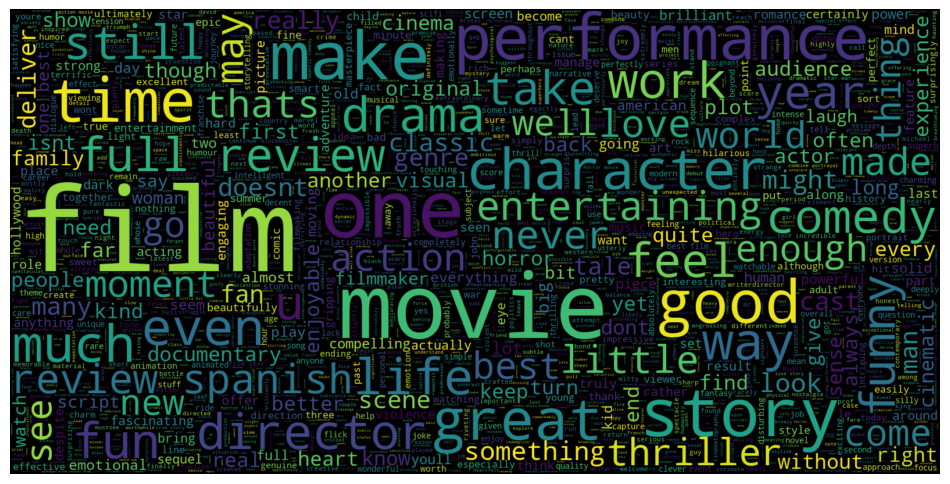

In [7]:
# WordCloud for positive reviews:
positive_reviews = reviews_df[reviews_df["review_type"] == 1].review_content
positive_reviews_text = " ".join(positive_reviews)

wordcloud = WordCloud(
    max_words=2000, width=1600, height=800, max_font_size=200
).generate(positive_reviews_text)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

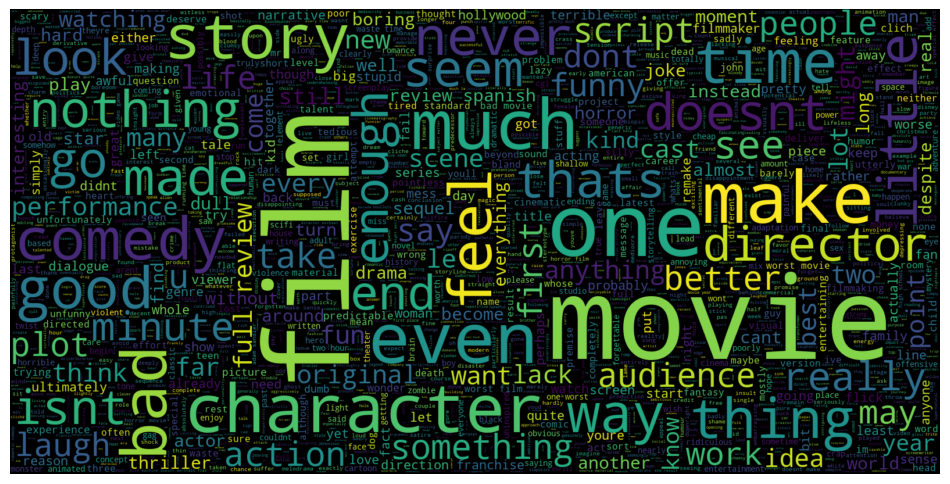

In [8]:
# WordCloud for negative reviews:
negative_reviews = reviews_df[reviews_df["review_type"] == 0].review_content
negative_reviews_text = " ".join(negative_reviews)

wordcloud = WordCloud(
    max_words=2000, width=1600, height=800, max_font_size=200
).generate(negative_reviews_text)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

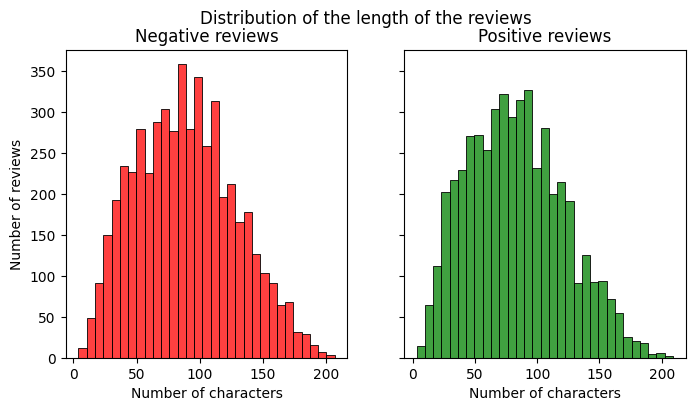

In [9]:
# Let's have a look at the length of the reviews
#   (in terms of number of characters).
text_len_neg = negative_reviews.str.len()
text_len_pos = positive_reviews.str.len()

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
sns.histplot(
    text_len_neg, ax=ax[0], color="red", label="Negative reviews", multiple="dodge"
)
sns.histplot(
    text_len_pos, ax=ax[1], color="green", label="Positive reviews", multiple="dodge"
)

ax[0].set_title("Negative reviews")
ax[0].set_xlabel("Number of characters")
ax[0].set_ylabel("Number of reviews")

ax[1].set_title("Positive reviews")
ax[1].set_xlabel("Number of characters")
ax[1].set_ylabel("Number of reviews")

fig.suptitle("Distribution of the length of the reviews")
plt.show()

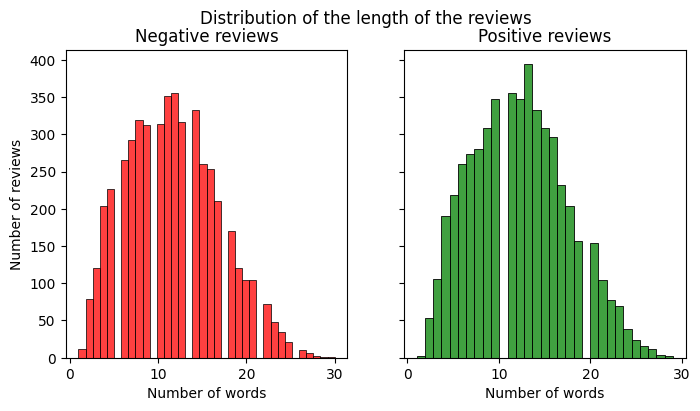

In [10]:
#   (and now in terms of number of words)

text_wc_neg = negative_reviews.str.split().map(lambda x: len(x))
text_wc_pos = positive_reviews.str.split().map(lambda x: len(x))

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

sns.histplot(
    text_wc_neg, ax=ax[0], color="red", label="Negative reviews", multiple="dodge"
)
sns.histplot(
    text_wc_pos, ax=ax[1], color="green", label="Positive reviews", multiple="dodge"
)

ax[0].set_title("Negative reviews")
ax[0].set_xlabel("Number of words")
ax[0].set_ylabel("Number of reviews")

ax[1].set_title("Positive reviews")
ax[1].set_xlabel("Number of words")
ax[1].set_ylabel("Number of reviews")

fig.suptitle("Distribution of the length of the reviews")
plt.show()

----------------

In [34]:
# Let's get started with BERT

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
class BertForSentimentAnalysis(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 2) # 768 is the output dimension of BERT model
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [37]:
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    for step, batch in enumerate(train_dataloader):
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy_score(torch.argmax(logits, axis=1).cpu().numpy(), labels.cpu().numpy())
    return total_loss/len(train_dataloader), total_acc/len(train_dataloader)


def evaluate(model, val_dataloader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for step, batch in enumerate(val_dataloader):
            input_ids, attention_mask, labels = batch
            logits = model(input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            total_acc += accuracy_score(torch.argmax(logits, axis=1).cpu().numpy(), labels.cpu().numpy())
    return total_loss/len(val_dataloader), total_acc/len(val_dataloader)

In [43]:
reviews_df = pd.read_csv("preprocessed_reviews.csv")

perc = 0.1
# Sample just the 10% of the data
reviews_df = reviews_df.sample(frac=perc, random_state=42)

X = reviews_df['review_content']
y = reviews_df['review_type']

# Tokenize the input text

# From the histogram above we can see that all the reviews
# are shorter than 30 tokens.
my_max_length = 30

inputs = tokenizer(list(X), padding=True, truncation=True, max_length=my_max_length, return_tensors='pt')
labels = torch.tensor(list(y))

# Split the data into train, validation and test sets
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [44]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [45]:
model = BertForSentimentAnalysis(bert_model)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [46]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_dataloader, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Training Accuracy: {train_acc:.4f} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_acc:.4f}')


Epoch 1/5 - Training Loss: 0.6784 - Training Accuracy: 0.5666 - Validation Loss: 0.5704 - Validation Accuracy: 0.7500
Epoch 2/5 - Training Loss: 0.5455 - Training Accuracy: 0.7316 - Validation Loss: 0.4368 - Validation Accuracy: 0.8125
Epoch 3/5 - Training Loss: 0.3548 - Training Accuracy: 0.8570 - Validation Loss: 0.4110 - Validation Accuracy: 0.8281
Epoch 4/5 - Training Loss: 0.1958 - Training Accuracy: 0.9363 - Validation Loss: 0.4217 - Validation Accuracy: 0.8359
Epoch 5/5 - Training Loss: 0.1102 - Training Accuracy: 0.9602 - Validation Loss: 0.5600 - Validation Accuracy: 0.8281


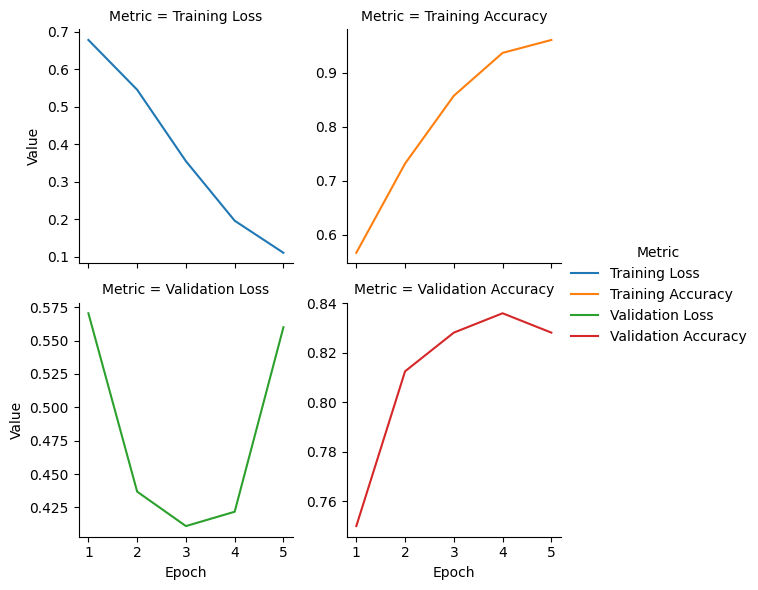

In [47]:
data = {
    'Epoch': range(1, num_epochs+1),
    'Training Loss': train_losses,
    'Training Accuracy': train_accs,
    'Validation Loss': val_losses,
    'Validation Accuracy': val_accs
}
trends = pd.DataFrame(data)

trends = trends.melt(id_vars=['Epoch'], var_name='Metric', value_name='Value')

# Create a facet grid with subplots for each metric
g = sns.FacetGrid(trends, col='Metric', hue='Metric', col_wrap=2, sharey=False)
g.map(sns.lineplot, 'Epoch', 'Value')

# Set the axis labels and legend
g.set_axis_labels('Epoch', 'Value')
g.add_legend()

# Show the plot
plt.show()

In [62]:
def custom_test(text):
    inputs = tokenizer(text, return_tensors='pt')

    # Make a prediction with the model
    outputs = model(inputs['input_ids'], inputs['attention_mask'])
    predicted_class = torch.argmax(outputs[0])

    # Print the predicted sentiment
    if predicted_class == 1:
        print('Fresh')
    else:
        print('Rotten')
        
    # return outputs

In [64]:
print('I love this movie!')
custom_test("I love this movie!")
print('I hate this movie!')
custom_test("I hate this movie!")
print('It was boring as fuck!')
custom_test('It was boring as fuck!')
print('The hell.. it was great!')
custom_test('The hell.. it was great!')
print("I don't know what to say..")
custom_test("I don't know what to say..")
print("I don't know what to say more than 'gorgeous!'")
custom_test("I don't know what to say more than 'gorgeous!'")
print("I don't know what to say more than it's gorgeous!")
custom_test("I don't know what to say more than it's gorgeous!")
print("'gorgeous'")
custom_test("'gorgeous'")
print("I would rewatch 1000 times!")
custom_test("I would rewatch 1000 times!")
print("I would never rewatch!")
custom_test("I would never rewatch!")

I love this movie!
Fresh
I hate this movie!
Rotten
It was boring as fuck!
Rotten
The hell.. it was great!
Fresh
I don't know what to say..
Rotten
I don't know what to say more than 'gorgeous!'
Rotten
I don't know what to say more than it's gorgeous!
Fresh
'gorgeous'
Fresh
I would rewatch 1000 times!
Rotten
I would never rewatch!
Rotten


In [ ]:
# It's not a bad way to start, considering that we are training only on 10% of the data.